In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
# Number of Training Datapoints 
n = 100000
# Number of Test Datapoints 
m = 1000

learning_rate = 0.1

In [ ]:
def onehotify(tensor):
  vocab = {'A':'1','C':'2', 'G':'3', 'T':'4'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot

def try_oneshot(element): 
  element['seq'] = tf.reshape(onehotify(element['seq']),(1,-1))
  element['label'] = tf.reshape(tf.one_hot(element['label'], 10),(1,-1))
  return element

In [ ]:
## Load Data into test and trainingdata 

ds_train, ds_test = tfds.load(name = 'genomics_ood',split=['train','test'], shuffle_files=True)

# Make datasets smaller 
ds_train = ds_train.take(n)
ds_test = ds_test.take(m)

## Convert to one hot vector
ds_train = ds_train.take(n).map(try_oneshot)

ds_test = ds_test.take(m).map(try_oneshot)

ds_test.element_spec

{'domain': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(1, 10), dtype=tf.float32, name=None),
 'seq': TensorSpec(shape=(1, None), dtype=tf.float32, name=None),
 'seq_info': TensorSpec(shape=(), dtype=tf.string, name=None)}

In [ ]:
# We will implement a simple fully connected feed forward neural network like the last time.
#
# Our network will have the following layers:
# Input : 784 units.
# Hidden layer 1: 256 units. With sigmoid activation function.
# Hidden layer 2: 256 units. With sigmoid activation function.
# Output: 10 units. With softmax activation function.
# 
# Instead of implementing our own layer we can directly implement the network using pre-built layers 
# from TensorFlow.
# For that check out 'tf.keras.layers.Dense(units= , activation=)'. It is basically the same layer that we
# implemented by hand last time.
# For activations functions check out 'tf.keras.activations'.

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for example in test_data:
    input = example['seq']
    target = example['label']
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  


In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.01
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, ds_test, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, ds_train, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):

    print('Epoch: __ ' + str(epoch))


    ds_train = ds_train.shuffle(buffer_size=128)
    ds_test = ds_test.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for example in ds_train:
        input = example['seq']
        target = example['label']
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, ds_test, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


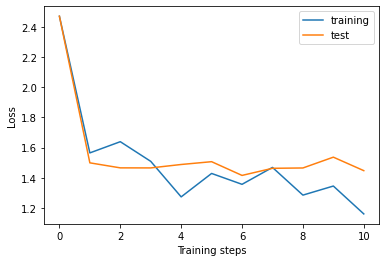

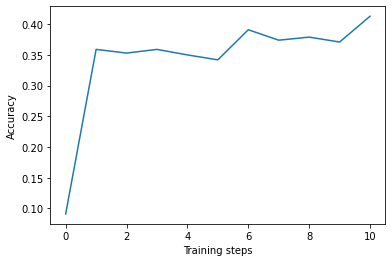

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()
